In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2
a = np.load('pose_result__data_paper_180918_MDN_PR_Fly1_001_SG1_behData_images.pkl')
data = a['points3d'].copy()
print('The dimension is ')
print(data.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dimension is 
(899, 38, 3)


In [13]:
def leg_len(data, t, leg, pos):
    '''pos = 0,1,2,3  t = 0 , leg = left:0, 5, 10,  right:19, 24, 29'''
    ex_point = data[t,leg+pos,:]
    next_point = data[t,leg+pos+1,:]
    nxt_v = next_point - ex_point
    return np.linalg.norm(nxt_v), nxt_v
def rotaMatr(v1,v2):
    u = np.cross(v1,v2)
    u = u/np.linalg.norm(u)
    th = intersection_angle(v1,v2)
    r = np.zeros((3,3))
    c = np.cos(th)
    s = np.sin(th)
    ux = u[0]
    uy = u[1]
    uz = u[2]
    r[0,0] = c + ux**2*(1-c)
    r[0,1] = ux*uy*(1-c) - uz*s
    r[0,2] = ux*uz*(1-c) + uy*s
    
    r[1,0] = ux*uy*(1-c) + uz*s
    r[1,1] = c + uy**2*(1-c)
    r[1,2] = uy*uz*(1-c) - ux*s
    
    r[2,0] = uz*ux*(1-c) - uy*s
    r[2,1] = uz*uy*(1-c) + ux*s
    r[2,2] = c + uz**2*(1-c)
    return r
def intersection_angle(a,b):
    return np.arccos(a@b/np.linalg.norm(a)/np.linalg.norm(b))
def ag2(angle):
    return angle/np.pi*180
def set_coord():
    v_ref = np.array([0,0,1])
    v1 = data[0,0,:] - data[0,19,:]
    v2 = data[0,5,:] - data[0,24,:]
    v3 = data[0,10,:] - data[0,29,:]
    v4 = data[0,15,:] - data[0,34,:]
    print(ag2(intersection_angle(v_ref,v1)))
    print(ag2(intersection_angle(v_ref,v2)))
    print(ag2(intersection_angle(v_ref,v3)))
    print(ag2(intersection_angle(v_ref,v4)))
    xx = v1+v2+v3+v4
    x_ref = xx/np.linalg.norm(xx)
    print(x_ref)
    x_ref[1] = 0
    print(x_ref)
    print('x-axis angel: ',ag2(intersection_angle(v_ref,x_ref)))
    return x_ref
coord_x = set_coord()
#an = 38/180*np.pi
#x_ref = np.array([np.sin(an),0,np.cos(an)])
#print(x_ref)

#coord_x = x_ref
coord_y = np.array([0,-1,0])
coord_z = np.cross(coord_x,coord_y)
print('left-coordinate x :', coord_x)
print('left-coordinate y :', coord_y)
print('left-coordinate z :', coord_z)
legname = ['left front', 'left middle', 'left hind', 'right front', 'right middle', 'right hind']

39.719173687676225
37.766569550937106
40.96779343467542
38.55254876567842
[0.62771434 0.07004704 0.77528583]
[0.62771434 0.         0.77528583]
x-axis angel:  38.99554730142681
left-coordinate x : [0.62771434 0.         0.77528583]
left-coordinate y : [ 0 -1  0]
left-coordinate z : [ 0.77528583  0.         -0.62771434]


In [22]:
R_std = rotaMatr(coord_x,np.array([0,0,1]))
std_data = np.zeros(data.shape)
for i in range(899):
    std_data[i,:,:] = (R_std @ (data[i,:].T)).T
tt = 899
length = np.zeros((tt,24))
vec_r = np.zeros((tt,24,3))
for ti in range(0,tt):
    i = 0
    for leg in [0,5,10,19,24,29]:
        for pos in range(4):
            length[ti,i+pos],vec_r[ti,i+pos] = leg_len(std_data,ti,leg,pos)
        i += 4

In [23]:
for ti in range(400,401):
    for i in range(6):
        vec_set = vec_r[ti,i*4:(i+1)*4]
        print(legname[i])
        print('The condition number is :%.1f'%np.linalg.cond(vec_set))
        print('The singular values are: %s\n'%np.linalg.svd(vec_set)[1])

left front
The condition number is :12.7
The singular values are: [0.97835227 0.70674228 0.07728894]

left middle
The condition number is :108.8
The singular values are: [1.20013383 0.98820656 0.01102799]

left hind
The condition number is :39.9
The singular values are: [1.35346598 0.8921857  0.0339525 ]

right front
The condition number is :5.8
The singular values are: [0.9512098  0.79050135 0.16340753]

right middle
The condition number is :8.3
The singular values are: [1.20752734 0.92893202 0.14615791]

right hind
The condition number is :16.4
The singular values are: [1.23222083 0.93586612 0.07502368]



In [80]:
def condtime():
    leg_cond = np.zeros((6,899))
    for t in range(899):
        for i in range(6):
            vec_set = vec_r[t,i*4:(i+1)*4]
            leg_cond[i,t] = np.linalg.cond(vec_set)
    return leg_cond
leg_cond = condtime()

In [81]:
def condtime2():
    leg_cond = np.zeros((6,899))
    for t in range(899):
        for j,i in enumerate([0,5,10,19,24,29]):
            vec_set = data[t,i:i+4,:]
            vec_set -= np.mean(vec_set, axis=0)
            leg_cond[j,t] = np.linalg.cond(vec_set)
    return leg_cond
leg_cond2 = condtime2()

In [93]:
def condtime():
    leg_cond = np.zeros((6,899))
    for t in range(899):
        for i in range(6):
            vec_set = vec_r[t,i*3:(i+1)*3]
            leg_cond[i,t] = np.linalg.cond(vec_set)
    return leg_cond
leg_cond3 = condtime()

In [82]:
leg_cond2 = 1 / leg_cond2

In [83]:
leg_cond = 1 / leg_cond

In [94]:
leg_cond3 = 1 / leg_cond3

Text(0.5, 0, 'Time (s)')

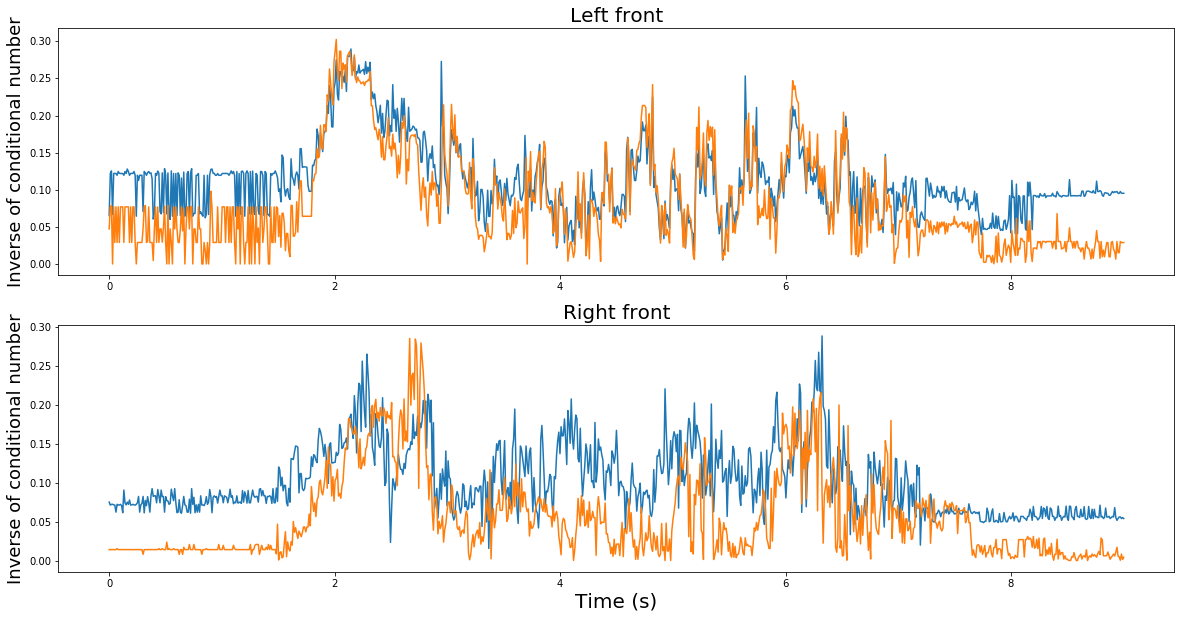

In [96]:
t = np.linspace(0,9,899)
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (20,10))
ax1.plot(t,leg_cond[0])
#ax1.plot(t,leg_cond2[0])
ax1.plot(t,leg_cond3[0])
ax1.set_title('Left front', fontsize='20')
ax1.set_ylabel('Inverse of conditional number', fontsize='18')
#ax1.set_xlabel('time', fontsize='15')

ax2.plot(t,leg_cond[3])
#ax2.plot(t,leg_cond2[3])
ax2.plot(t,leg_cond3[3])
ax2.set_title('Right front', fontsize='20')
ax2.set_ylabel('Inverse of conditional number', fontsize='18')
ax2.set_xlabel('Time (s)', fontsize='20')

Text(0.5, 0, 'Time (s)')

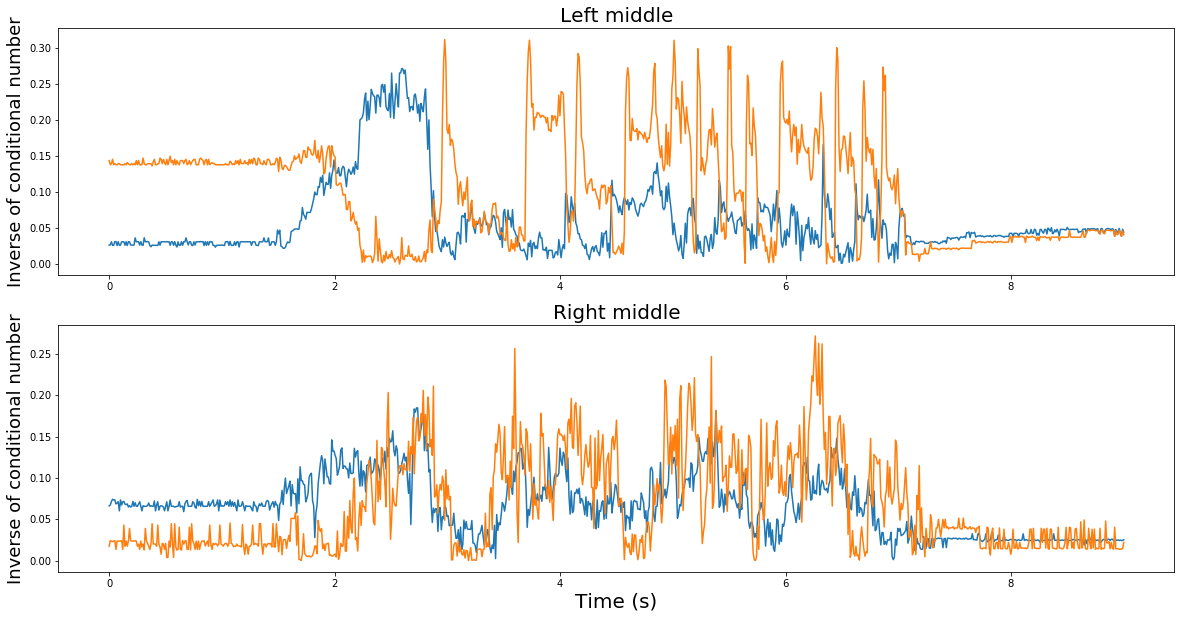

In [97]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (20,10))
ax1.plot(t,leg_cond[1])
ax1.plot(t,leg_cond3[1])
ax1.set_title('Left middle', fontsize='20')
ax1.set_ylabel('Inverse of conditional number', fontsize='18')
#ax1.set_xlabel('time', fontsize='15')

ax2.plot(t,leg_cond[4])
ax2.plot(t,leg_cond3[4])
ax2.set_title('Right middle', fontsize='20')
ax2.set_ylabel('Inverse of conditional number', fontsize='18')
ax2.set_xlabel('Time (s)', fontsize='20')

Text(0.5, 0, 'Time (s)')

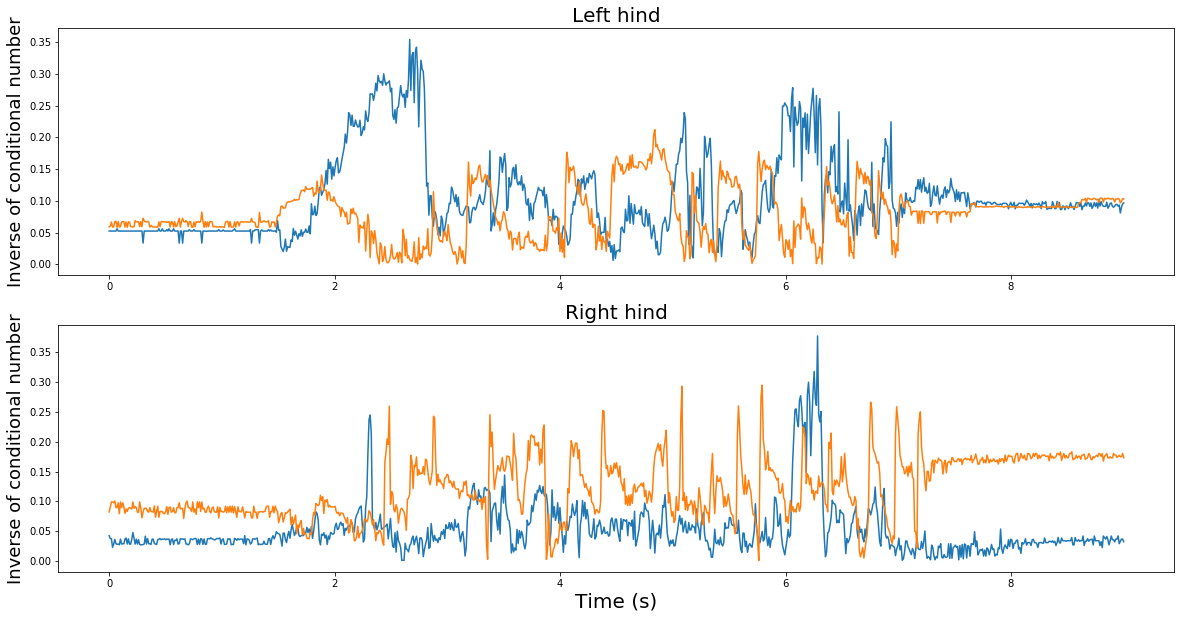

In [98]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize = (20,10))
ax1.plot(t,leg_cond[2])
ax1.plot(t,leg_cond3[2])
ax1.set_title('Left hind', fontsize='20')
ax1.set_ylabel('Inverse of conditional number', fontsize='18')
#ax1.set_xlabel('time', fontsize='15')

ax2.plot(t,leg_cond[5])
ax2.plot(t,leg_cond3[5])
ax2.set_title('Right hind', fontsize='20')
ax2.set_ylabel('Inverse of conditional number', fontsize='18')
ax2.set_xlabel('Time (s)', fontsize='20')
#ax2.set_ybound(0,200)

In [70]:
fig.savefig('../../Pictures/condition_number.jpg')

In [46]:
print('for right hind leg: ')
print(leg_cond[5,np.where(leg_cond[5]<10)])
print(np.where(leg_cond[5]<10))

for right hind leg: 
[[9.27458271 5.55163359 4.214373   4.08531558 4.67366502 9.67815837
  8.63029238 7.89845922 7.67499625 9.63551645 9.22768457 8.36885568
  9.29781448 9.18246146 9.92110721 8.19726944 8.10571921 8.47191656
  8.33794068 8.41410102 8.76680151 9.79599961 7.98739806 6.93409946
  8.87461514 9.81381194 8.42954431 8.64300105 7.88745981 8.53904551
  8.84325633 7.99019033 9.01675391 9.25668173 8.93580215 8.37678959
  9.88002136 9.84814119 8.97730748 9.32215726 9.46647429 9.37823755
  5.96271261 4.77562288 3.94429711 3.91715937 4.24883075 4.43901431
  3.71596094 3.60685702 3.90918746 4.62808747 4.39624331 4.30306533
  6.71439295 3.58266473 3.33449207 3.73734557 5.66082182 4.19047033
  3.53317399 3.14461328 3.66272438 3.82995042 2.64881951 4.07456519
  4.2857971  3.98638395 6.2951144  9.81419934 8.0514288  9.37335719
  8.22168724]]
(array([228, 229, 230, 231, 232, 320, 321, 322, 323, 324, 325, 327, 328,
       329, 331, 332, 333, 334, 335, 336, 337, 347, 348, 350, 377, 378,
   